 This notebook presents an example of implementation of the equal risk pricing framework as presented in "Deep equal risk pricing of financial derivatives with non-translation invariant risk measures" of Carbonneau and Godin (2021).
 
The equal risk option price $C_{0}^{\star}$ is computed under the class of semi-$\mathbb{L}^p$ risk measures for an at-the-money European-type put option of maturity 60 days under the Black-Scholes model model. 

- A) The deep hedging algorithm (Buehler et al., 2019) is used twice with two distinct feedforward neural networks to approximate the optimal hedging strategy respectively for the long and the short position in the derivative.
    - Our training algorithm follows the methodology presented in Section 4.2.2 of Carbonneau and Godin (2021), where the initial capital investment is sampled at the beginning of each SGD step. 
 
- B) The bisection algorithm is used to compute $C_0^{\star}$ with the trained neural networks
 
For a complete description of the algorithm, the reader is referred to Section 4 of the paper.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import tensorflow as tf
import random
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
def BS_d1(S, dt, r, sigma, strike):
    return (np.log(S/strike) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

# style: {1 for call, -1 for put}
def BlackScholes_price(S, T, r, sigma, strike, style, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, strike)
    d2 = d1 - sigma*np.sqrt(dt)
    return style*S*Phi(style*d1) - style*strike*np.exp(-r*dt)*Phi(style*d2)

### 1) Construction of the train and test sets
- A) Simulation of 500K paths under the Black-Scholes model with the parameters [sigma, mu] = [0.1952, 0.0892] on a yearly scale. 
- B) Split into train and test sets with 400K and 100K paths.

In [4]:
# Parameters
[sigma, mu]  = [0.1952, 0.0892] # Yearly parameters
S_0          = 100     # Initial stock price
strike       = 90     # Strike price
T            = 60/260  # Time-to-maturity of the vanilla put option
n_sims       = 500000  # Total number of paths to simulate
n_timesteps  = 60      # Daily hedging
r            = 0.02    # Annualized continuous risk-free rate

# Simulation of BSM dataset 
seed           = 10
h              = T / n_timesteps  # step-size
Price_mat      = np.zeros((n_timesteps+1, n_sims))  # matrix of simulated stock prices 
Price_mat[0,:] = S_0
for i in range(n_sims):
    rand_stdnorm     = np.random.randn(n_timesteps)
    Price_mat[1:,i]  = S_0 * np.cumprod(np.exp((mu-sigma**2/2)*h+sigma*np.sqrt(h)*rand_stdnorm))

# Apply a transformation to stock prices
prepro_stock = "Log-moneyness"  # {Log, Log-moneyness, Nothing}
if(prepro_stock == "Log"):
    Price_mat = np.log(Price_mat)
elif(prepro_stock == "Log-moneyness"):
    Price_mat = np.log(Price_mat/strike)

# Construct the train and test sets
# - The feature vector for now is [S_n, T-t_n]; the portfolio value V_{n} will be added further into the code at each time-step
train_input     = np.zeros((n_timesteps+1, 400000,2))
test_input      = np.zeros((n_timesteps+1, 100000,2))
time_to_mat     = np.zeros(n_timesteps+1)
time_to_mat[1:] = T / (n_timesteps)      # [0,h,h,h,..,h]                     
time_to_mat     = np.cumsum(time_to_mat) # [0,h,2h,...,Nh]
time_to_mat     = time_to_mat[::-1]      # [Nh, (N-1)h,...,h,0]

train_input[:,:,0] = Price_mat[:,0:400000]  
train_input[:,:,1] = np.reshape(np.repeat(time_to_mat, train_input.shape[1], axis=0), (n_timesteps+1, train_input.shape[1]))
test_input[:,:,0]  = Price_mat[:,400000:]
test_input[:,:,1]  = np.reshape(np.repeat(time_to_mat, test_input.shape[1], axis=0), (n_timesteps+1, test_input.shape[1]))

# Compute interval of initial portfolio values
RN        = BlackScholes_price(S_0, T, r, sigma, strike, -1)
V_0_range = [0.75*RN, 1.50*RN]
V_0_norm  = 0.5*(V_0_range[0] + V_0_range[1])

### 2) Hyperparameters of neural networks 

In [5]:
batch_size    = 1000   # batch size
epochs        = 30     # number of epochs
hidden_layers = 2      # number of hidden layers (output layer not included, for a total of three layers)
nbs_units     = 56     # neurons per layer
lr            = 0.0005 # learning rate of the Adam optimizer
p_param       = 2.00   # semi-L^p parameter 

### 3) Tensor of discount factors
- disc_mat: (n_timesteps+1 x n_sims x 1) tensor of cumulative discount rates (discount from t to 0), i.e. $\exp(-rh*n)$ 

In [6]:
disc_mat              = np.zeros((n_timesteps+1, 500000, 1))
disc_train            = np.zeros((n_timesteps+1, 400000, 1))
disc_test             = np.zeros((n_timesteps+1, 100000, 1))
discount_vect         = np.ones(disc_mat.shape[0])   
h                     = T / n_timesteps
discount_vect[1:]     = np.exp(-r*h)              # [1,exp(-rh), exp(-rh),....,exp(-rh)]
discount_vect         = np.cumprod(discount_vect) # [1,exp(-rh), exp(-r2h),....,exp(-rNh)]
disc_mat              = np.reshape(np.repeat(discount_vect, 500000), (n_timesteps+1, 500000,1))
disc_train            = disc_mat[:,0:400000,:]
disc_batch            = disc_mat[:,0:batch_size,:]  # for convenience when only batch-size is needed
disc_test             = disc_mat[:,400000:,:]
disc_mat              = []  

### 4) Deep hedging implementation

In [7]:
class DeepAgent(object):
    """
    Inputs:
    nbs_point_traj: if [S_0,...,S_T], nbs_point_traj = T+1, i.e. nbs_point_traj = nbs of rebalancement + 1
    batch_size    : size of the batch
    nbs_input     : number of features used
    position_type : {Long, Short}
    nbs_layers    : number of layers, valid for MLP and LSTM
    nbs_units     : fixed number of units per layer, valid for MLP or LSTM
    lr            : learning rate
    prepro_stock  : {Log, Log-moneyness, Nothing} - what transformation was used for stock prices
    strike        : Strike level of option to hedge
    V_0_norm      : normalization term for portfolio values
    p_param       : parameter for semi-L^p loss 
    name          : Model name to be saved
    """
    def __init__(self, nbs_point_traj, batch_size, nbs_input, position_type, 
        nbs_layers, nbs_units, lr, prepro_stock, strike, V_0_norm, p_param, name='model'):
    
        tf.reset_default_graph() # don't know what it does
        self.nbs_point_traj = nbs_point_traj
        self.batch_size     = batch_size
        self.nbs_input      = nbs_input
        self.position_type  = position_type
        self.nbs_layers     = nbs_layers
        self.nbs_units      = nbs_units
        self.lr             = lr
        self.prepro_stock   = prepro_stock  
        self.strike         = strike*tf.ones(self.batch_size)
        self.V_0_norm       = V_0_norm*self.batch_size
        self.p_param        = p_param
        
        # 1) Placeholders
        self.input        = tf.placeholder(tf.float32, [nbs_point_traj, batch_size, nbs_input])  
        self.disc_tensor  = tf.placeholder(tf.float32, [nbs_point_traj, batch_size, 1]) # To discount from 't' to 0.
        self.V_0          = tf.placeholder(tf.float32, [batch_size])
        self.deltas       = tf.zeros(shape = [nbs_point_traj-1, batch_size, 1], dtype=tf.float32)
        
        # 2) Discount prices computation:
        self.unorm_price  = self.inverse_processing(self.input[:,:,0], prepro_stock)   # (nbs_point_traj X batch_size)
        discount_price    = tf.multiply(self.unorm_price, self.disc_tensor[:,:,0])
        inc_disc_ret      = discount_price[1:,:] - discount_price[0:-1,:] # discounted difference in price

        # 3) Payoff of each path for ATM put option
        self.payoff = tf.maximum(self.strike - self.unorm_price[-1,:],0)
        
        # 4) Compute the deltas of the strategy with the deep hedging algorithm
        # 4.1) Two hidden layers with relu activation function
        layer_1   = tf.layers.Dense(self.nbs_units, tf.nn.relu)
        layer_2   = tf.layers.Dense(self.nbs_units, tf.nn.relu)
       
        # 4.2) Output layer of dimension one (outputs the position in the underlying)
        layer_out = tf.layers.Dense(1, None)
        
        # 4.3) Compute hedging strategies for all time-steps
        V_t = self.V_0/self.V_0_norm  # [batch_size]                                                
        for t in range(self.nbs_point_traj-1):     
            input_t = tf.concat([self.input[t,:,:], tf.expand_dims(V_t, axis = 1)], axis=1)  
            layer   = layer_1(input_t)
            layer   = layer_2(layer)         
            layer   = layer_out(layer)                
                
            # Compile the results
            if (t==0):
                self.deltas = layer      # [batch_size,1]
                self.deltas = tf.expand_dims(self.deltas, axis=0)  # [1, batch_size, 1]
                
            else:
                self.deltas = tf.concat([self.deltas, tf.expand_dims(layer, axis = 0)], axis = 0)
                
            # Compute the value for the next time-period
            factor  = tf.div(self.disc_tensor[t,:,0],self.disc_tensor[t+1,:,0]) # equal exp(rh)
            V_t_pre = tf.multiply(V_t, self.V_0_norm)
            V_t     = tf.divide(V_t_pre*factor + tf.reduce_sum(self.deltas[t,:,0]*(self.unorm_price[t+1,:] - self.unorm_price[t,:]*tf.expand_dims(factor, axis=1)), axis=1), self.V_0_norm)
        
        # 5) Compute the discounted gain at maturity for each paths
        cumulative_factor  = tf.reciprocal(self.disc_tensor[-1,:,0])                 # Project from 0 to T
        self.disc_gain     = tf.reduce_sum(inc_disc_ret*self.deltas[:,:,0], axis=0)  # G_{N}
        
        # 6) Compute hedging errors for each paths as if initial portfolio value is zero
        if(self.position_type == 'Short'):
            self.hedging_err = self.payoff - cumulative_factor*(self.disc_gain + self.V_0)
        elif(self.position_type == 'Long'):
            self.hedging_err = cumulative_factor*self.V_0 - self.payoff - cumulative_factor*self.disc_gain
        
        # 7) Compute empirial loss on minibatch
        self.loss  = tf.pow(tf.reduce_mean(tf.pow(tf.nn.relu(self.hedging_err), self.p_param)),1/self.p_param)
        
        # 8) SGD step with the adam optimizer
        optimizer  = tf.train.AdamOptimizer(learning_rate = lr)  
        self.train = optimizer.minimize(self.loss) 
        
        # 9) Save the model
        self.saver      = tf.train.Saver()
        self.model_name = name   # name of the neural network to save
    
    # given a pre-processing method for stock prices, compute the inverse of the pre-processing
    def inverse_processing(self, paths, prepro_stock):
        if (prepro_stock =="Log-moneyness"):
            paths = tf.multiply(self.strike, tf.exp(paths))  # should broadcast self.strike match
        elif (prepro_stock == "Log"):
            paths = tf.exp(paths)
        return paths
        
    # Function works outside the optimization 
    def loss_out_optim(self, hedging_err):
        loss = np.power(np.mean(np.power(np.where(hedging_err>0,hedging_err,0), self.p_param)), 1/self.p_param)
        return loss
    
    def train_deephedging(self, paths, disc_batch, V_0_range, sess, epochs):
        sample_size       = paths.shape[1]               # total number of paths in the train set
        batch_size        = self.batch_size    
        idx               = np.arange(sample_size)       # [0,1,...,sample_size-1]
        start             = dt.datetime.now()            # Time-to-train
        self.loss_epochs  = 9999999*np.ones(epochs)      # Store the loss at the end of each epoch for the train              
        epoch             = 0                       
        
        # Loop for each epoch until the maximum number of epochs
        while (epoch < epochs):
            hedging_err_train = []  # Store hedging errors obtained for one complete epoch 
            np.random.shuffle(idx)  # Randomize the dataset (not useful in this case since dataset is simulated iid)
            
            # loop over each batch size
            for i in range(int(sample_size/batch_size)):
                
                # Indexes of paths used for the mini-batch
                indices = idx[i*batch_size : (i+1)*batch_size]
                        
                # Sample initial value for V_0
                V_0     = np.random.uniform(low = V_0_range[0], high = V_0_range[1], size = 1)
                
                # SGD step 
                _, hedging_err = sess.run([self.train, self.hedging_err], 
                                               {self.input        : paths[:,indices,:],
                                                self.disc_tensor  : disc_batch,
                                                self.V_0          : V_0*np.ones(batch_size)})
            
                hedging_err_train.append(hedging_err)
            
            # Store the loss on the train set after each epoch
            self.loss_epochs[epoch] = self.loss_out_optim(np.concatenate(hedging_err_train))
            
            # Print the CVaR value at the end of each epoch
            print('Time elapsed:', dt.datetime.now()-start)
            print('Epoch %d, Train loss: %.3f' % (epoch+1, self.loss_epochs[epoch]))
                
            epoch+=1  # increment the epoch
                
        # End of training
        print("---Finished training results---")
        print('Time elapsed:', dt.datetime.now()-start)    
        self.saver.save(sess, r"/Users/alexa/Github files/ERP - semi Lp/Models/%s/models.ckpt" % self.model_name)
  
        # Return the learning curve 
        return self.loss_epochs

    def training(self, paths, disc_batch, sess, epochs, V_0_range):
        sess.run(tf.global_variables_initializer()) 
        loss_train_epoch = self.train_deephedging(paths, disc_batch, V_0_range, sess, epochs)
        return loss_train_epoch
        
    def predict(self, paths, V_0, disc_paths, sess):
        sample_size   = paths.shape[1]
        batch_size    = self.batch_size    
        idx           = np.arange(sample_size)  # [0,1,...,sample_size-1]
        start         = dt.datetime.now()     # compute time
        strategy_pred = [] # hedging strategies
            
        # loop over sample size to do one complete epoch
        for i in range(int(sample_size/batch_size)):
            indices    = idx[i*batch_size : (i+1)*batch_size]
            hedging_err, strategy = sess.run([self.hedging_err, self.deltas], 
                                                 {self.input        : paths[:,indices,:],
                                                  self.disc_tensor  : disc_batch,
                                                  self.V_0          : V_0*np.ones(batch_size)})
            
            # This is the batch of input: (nbs_point_traj x indices x 1)
            strategy_pred.append(strategy)

        return np.concatenate(strategy_pred,axis=1)   
         
    def restore(self, sess, checkpoint):
        self.saver.restore(sess, checkpoint)

### 5) Function to compute the measured risk exposure given a sample of paths and hedging decisions

In [12]:
#-------------------------------------------------------------------------------------------------#
#---------------      Functions to evaluate the measured risk exposure       ---------------------#
#-------------------------------------------------------------------------------------------------#
""" 
Input:
- deltas       : (time step x nbs of paths) 
- paths        : (time step x nbs of paths)  
- disc_paths   : (time step x nbs of paths x 1)
- strike       : strike of put option to hedge
- p_param      : parameter for semi-L^p loss 
- position_type: {Long, Short}
- prepro_stock : {Log, Log-moneyness, Nothing} - what transformation was used for stock prices
- V_0          : Initial portfolio value
"""
#-------------------------------------------------------------------------------------------------#
def measured_risk_exposures(deltas, paths, disc_paths, strike, p_param, position_type, prepro_stock, V_0):
    
    # De-normalize the stock price process
    if(prepro_stock == "Log"):
        paths = np.exp(paths)
    elif(prepro_stock == "Log-moneyness"):
        paths = strike*np.exp(paths)
        
    # Discounted prices and returns for each paths at each timesteps
    discount_price    = np.multiply(paths, disc_paths[:,:,0])          # exp(-rh*n)*S_{n} 
    inc_disc_ret      = discount_price[1:,:] - discount_price[0:-1,:]  # Increment of discount returns
    
    # Option payoff of vanilla ATM put
    option_payoff     = np.maximum(strike - paths[-1,:],0) 
    
    # Discounted gain process
    disc_gain         = np.sum(deltas*inc_disc_ret, axis = 0)  # G_{N}
    cumulative_factor = np.reciprocal(disc_paths[-1,:,0])      # B_{N}
     
    if(position_type == 'Short'):
        hedging_err = option_payoff - cumulative_factor*(disc_gain + V_0)
    elif(position_type == 'Long'):
        hedging_err = cumulative_factor*V_0 -option_payoff - cumulative_factor*disc_gain
        
    # Empirical semi-L^p computation
    loss = np.power(np.sqrt(np.mean(np.power(np.where(hedging_err>0,hedging_err,0), p_param))), 1/p_param)
    return loss

### 6) Training of short position neural network

Hyperparameters: learning rate=0.0005, layers=2, neurons=56
---Training start---
Time elapsed: 0:00:25.854143
Epoch 1, Train loss: 0.618
Time elapsed: 0:00:46.656478
Epoch 2, Train loss: 0.202
Time elapsed: 0:01:07.116147
Epoch 3, Train loss: 0.178
Time elapsed: 0:01:27.546343
Epoch 4, Train loss: 0.171
Time elapsed: 0:01:47.988638
Epoch 5, Train loss: 0.160
Time elapsed: 0:02:08.673402
Epoch 6, Train loss: 0.163
Time elapsed: 0:02:29.510140
Epoch 7, Train loss: 0.159
Time elapsed: 0:02:49.961708
Epoch 8, Train loss: 0.159
Time elapsed: 0:03:10.869478
Epoch 9, Train loss: 0.159
Time elapsed: 0:03:32.088593
Epoch 10, Train loss: 0.157
Time elapsed: 0:03:52.768295
Epoch 11, Train loss: 0.156
Time elapsed: 0:04:13.338060
Epoch 12, Train loss: 0.154
Time elapsed: 0:04:33.800544
Epoch 13, Train loss: 0.154
Time elapsed: 0:04:54.446912
Epoch 14, Train loss: 0.156
Time elapsed: 0:05:15.061405
Epoch 15, Train loss: 0.155
Time elapsed: 0:05:35.432071
Epoch 16, Train loss: 0.154
Time elapsed: 0:

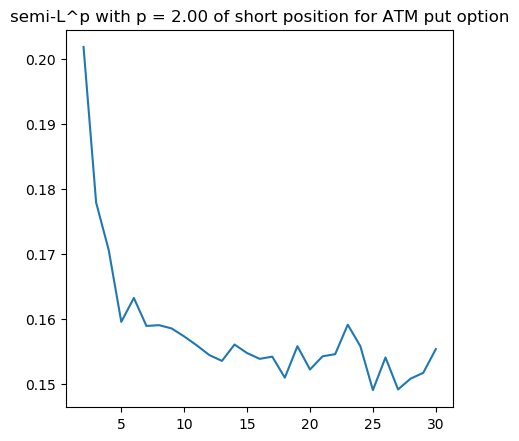

In [9]:
position_type    = 'Short'
model_name_short = "Short_FFNN"
print("Hyperparameters: learning rate=%.4f, layers=%d, neurons=%d" %(lr, hidden_layers, nbs_units))

# Compile the neural network
FFNN_short = DeepAgent(train_input.shape[0], batch_size, train_input.shape[2], position_type, hidden_layers, 
                        nbs_units, lr, prepro_stock, strike, V_0_norm, p_param, model_name_short)
    
# Start training 
start = dt.datetime.now()
print('---Training start---')
with tf.Session() as sess:
    loss_train_epoch = FFNN_short.training(train_input, disc_batch, sess, epochs, V_0_range)
   
    print('---Training end---')

# Plot the learning curve on the train set, i.e. the semi-L^p on the train set at the end of each epoch
lin_nb_epoch = np.linspace(1, loss_train_epoch.shape[0], loss_train_epoch.shape[0])
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(lin_nb_epoch[1:], loss_train_epoch[1:])
plt.title('semi-L^p with p = %.2f of short position for ATM put option' %(p_param))
plt.show()

### 7) Training of long position neural network

Hyperparameters: learning rate=0.0005, layers=2, neurons=56
---Training start---
Time elapsed: 0:00:25.490782
Epoch 1, Train loss: 0.375
Time elapsed: 0:00:46.532793
Epoch 2, Train loss: 0.259
Time elapsed: 0:01:07.029467
Epoch 3, Train loss: 0.242
Time elapsed: 0:01:26.964653
Epoch 4, Train loss: 0.233
Time elapsed: 0:01:46.520937
Epoch 5, Train loss: 0.220
Time elapsed: 0:02:06.201630
Epoch 6, Train loss: 0.218
Time elapsed: 0:02:25.987859
Epoch 7, Train loss: 0.227
Time elapsed: 0:02:46.120555
Epoch 8, Train loss: 0.218
Time elapsed: 0:03:06.570841
Epoch 9, Train loss: 0.209
Time elapsed: 0:03:26.996238
Epoch 10, Train loss: 0.216
Time elapsed: 0:03:47.302520
Epoch 11, Train loss: 0.219
Time elapsed: 0:04:07.230611
Epoch 12, Train loss: 0.211
Time elapsed: 0:04:28.030541
Epoch 13, Train loss: 0.218
Time elapsed: 0:04:48.218201
Epoch 14, Train loss: 0.220
Time elapsed: 0:05:07.863659
Epoch 15, Train loss: 0.212
Time elapsed: 0:05:27.626978
Epoch 16, Train loss: 0.212
Time elapsed: 0:

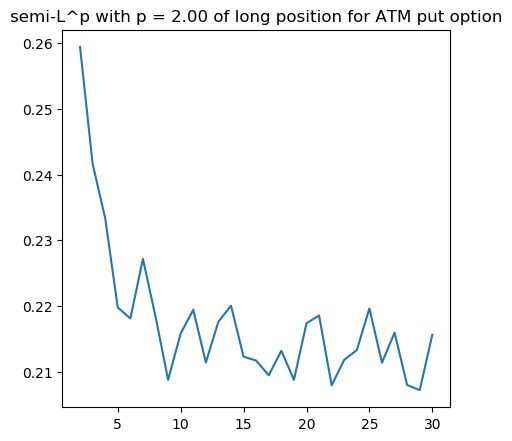

In [10]:
position_type   = 'Long'
model_name_long = "Long_FFNN"
print("Hyperparameters: learning rate=%.4f, layers=%d, neurons=%d" %(lr, hidden_layers, nbs_units))

# Compile the neural network
FFNN_long = DeepAgent(train_input.shape[0], batch_size, train_input.shape[2], position_type, hidden_layers, 
                        nbs_units, lr, prepro_stock, strike, V_0_norm, p_param, model_name_long)
    
# Start training 
start = dt.datetime.now()
print('---Training start---')
with tf.Session() as sess:
    loss_train_epoch = FFNN_long.training(train_input, disc_batch, sess, epochs, V_0_range)
   
    print('---Training end---')

# Plot the learning curve on the train set, i.e. the semi-L^p on the train set at the end of each epoch
lin_nb_epoch = np.linspace(1, loss_train_epoch.shape[0], loss_train_epoch.shape[0])
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(lin_nb_epoch[1:], loss_train_epoch[1:])
plt.title('semi-L^p with p = %.2f of long position for ATM put option' %(p_param))
plt.show()

### 8) Bisection approach to compute $C_0^{\star}$

In [13]:
nbs_loop_max = 100
epsilon_crit = 0.01
err_delta_V0 = 999999
iter_idx     = 0

while (np.abs(err_delta_V0) > epsilon_crit and iter_idx < nbs_loop_max):
    # 1) compute V_0 at which we will evaluate delta_V0 
    V_0_mid = np.average(V_0_range)
    
    # 2) Compute residual risk at V_0_mid for the short position
    model_predict_short = DeepAgent(test_input.shape[0], batch_size, test_input.shape[2], position_type, 
            hidden_layers, nbs_units, lr, prepro_stock, strike, V_0_norm, p_param, model_name_short)

    with tf.Session() as sess:
        model_predict_short.restore(sess, r"/Users/alexa/Github files/ERP - semi Lp/Models/%s/models.ckpt" % model_name_short)
        deltas_short = model_predict_short.predict(test_input, V_0_mid, disc_test, sess)
        loss_SMSE_short =  measured_risk_exposures(deltas_short[:,:,0], test_input[:,:,0], disc_test, strike, p_param, 'Short',
                                                  prepro_stock, V_0_mid)        
        
    # 3) Compute residual risk at V_0_mid for the long position
    model_predict_long = DeepAgent(test_input.shape[0], batch_size, test_input.shape[2], position_type, 
            hidden_layers, nbs_units, lr, prepro_stock, strike, V_0_norm, p_param, model_name_long)

    with tf.Session() as sess:
        model_predict_long.restore(sess, r"/Users/alexa/Github files/ERP - semi Lp/Models/%s/models.ckpt" % model_name_long)
        deltas_long = model_predict_long.predict(test_input, V_0_mid, disc_test, sess)
        loss_SMSE_long =  measured_risk_exposures(deltas_long[:,:,0], test_input[:,:,0], disc_test, strike, p_param, 'Long',
                                                  prepro_stock, V_0_mid)            
    
    # 4) Compute delta_V0_func
    err_delta_V0 = loss_SMSE_short - loss_SMSE_long
    
    print("---------------------------------------")
    print("---------------------------------------")
    print("Delta_V0 = %.4f for iteration %d" %(err_delta_V0, iter_idx+1))
    print("Current price estimate: %.4f" %(V_0_mid))
    print("Loss short = %.4f, loss long = %.4f" %(loss_SMSE_short, loss_SMSE_long))
    
    # 5) Check if delta_V0_func > 0 or delta_V0_func < 0    
    if (err_delta_V0 > 0): # V_0 is too small
        V_0_range = np.array([V_0_mid, V_0_range[1]])
    
    elif (err_delta_V0 < 0):
        V_0_range = np.array([V_0_range[0], V_0_mid])     
    
    #print("Mid price = %.4f" %(V_0_mid))
    #print(V_0_range)
    iter_idx += 1
    print("---------------------------------------")
    print("---------------------------------------")

print("---------------------------------------")
print("---------------------------------------")
print("You are done!")
print("Total number of iterations: %d" %(iter_idx))
print("Final price: %.4f" %(V_0_mid))

INFO:tensorflow:Restoring parameters from /Users/alexa/Github files/ERP - semi Lp/Models/Short_FFNN/models.ckpt
INFO:tensorflow:Restoring parameters from /Users/alexa/Github files/ERP - semi Lp/Models/Long_FFNN/models.ckpt
---------------------------------------
---------------------------------------
Delta_V0 = -0.0582 for iteration 1
Current price estimate: 0.5917
Loss short = 0.3720, loss long = 0.4302
---------------------------------------
---------------------------------------
INFO:tensorflow:Restoring parameters from /Users/alexa/Github files/ERP - semi Lp/Models/Short_FFNN/models.ckpt
INFO:tensorflow:Restoring parameters from /Users/alexa/Github files/ERP - semi Lp/Models/Long_FFNN/models.ckpt
---------------------------------------
---------------------------------------
Delta_V0 = 0.0740 for iteration 2
Current price estimate: 0.4931
Loss short = 0.4290, loss long = 0.3550
---------------------------------------
---------------------------------------
INFO:tensorflow:Restori

References
- Buehler, H., Gonon, L., Teichmann, J., and Wood, B. (2019b). Deep hedging. Quantitative Finance, 19(8):1271-1291.
- Carbonneau, A. and Godin, F. (2021). Deep equal risk pricing of financial derivatives with non-translation invariant risk measures.